In [3]:
import os

# Path to check
kaggle_path = os.path.expanduser("~/.kaggle/kaggle.json")

# Check if it exists
if os.path.exists(kaggle_path):
    print("✅ kaggle.json is present.")
else:
    print("❌ kaggle.json is missing.")


✅ kaggle.json is present.


In [4]:
# Download dataset from kaggle
!kaggle datasets download -d sdrasco/medicare-physician-provider-and-service-resampled


Dataset URL: https://www.kaggle.com/datasets/sdrasco/medicare-physician-provider-and-service-resampled
License(s): CC0-1.0
medicare-physician-provider-and-service-resampled.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
# Unzipping downloaded file
import zipfile

with zipfile.ZipFile("medicare-physician-provider-and-service-resampled.zip", 'r') as zip_ref:
    zip_ref.extractall(".")  # Extracts to current directory

In [6]:
import pandas as pd

df = pd.read_csv("medicare-physician-provider-and-service-resampled.zip")

C:\Users\PC\AppData\Local\Temp\ipykernel_6124\2190450939.py:3: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("medicare-physician-provider-and-service-resampled.zip")


In [7]:
df = pd.read_csv("medicare-physician-provider-and-service-resampled.zip", 
                 dtype={df.columns[12]: str})
df.head()


,Rndrng_NPI,Rndrng_Prvdr_Last_Org_Name,Rndrng_Prvdr_First_Name,Rndrng_Prvdr_MI,Rndrng_Prvdr_Crdntls,Rndrng_Prvdr_Gndr,Rndrng_Prvdr_Ent_Cd,Rndrng_Prvdr_St1,Rndrng_Prvdr_St2,Rndrng_Prvdr_City,...,HCPCS_Desc,HCPCS_Drug_Ind,Place_Of_Srvc,Tot_Benes,Tot_Srvcs,Tot_Bene_Day_Srvcs,Avg_Sbmtd_Chrg,Avg_Mdcr_Alowd_Amt,Avg_Mdcr_Pymt_Amt,Avg_Mdcr_Stdzd_Amt
0,1124164496,Zirilli,Thomas,A,PT,M,I,7037 Manlius Center Rd,NaN,East Syracuse,...,"Evaluation for physical therapy, typically 30 ...",N,O,77,87.0,87,125.000000,98.120230,71.887011,74.188621
1,1922254275,Lipovic,Daniela,NaN,DO,F,I,199 Amsterdam Ave,NaN,New York,...,"New patient office or other outpatient visit, ...",N,O,15,15.0,15,375.333333,199.710667,178.628000,148.452000
2,1104803436,Rogoff,Michael,A,M.D.,M,I,4302 Alton Rd,Suite 300,Miami Beach,...,Review by radiologist of additional artery image,N,O,16,39.0,22,219.333333,100.618462,80.323333,78.953590
3,1871576157,Manda,Timothy,J,MD,M,I,100 South Ashley Drive,Suite 1500,Tampa,...,Screening mammography,N,F,140,140.0,140,259.000000,36.483214,36.483214,36.290000
4,1124360359,Shaw,Amy,L,MD,F,I,525 E. 68th St.,Payson 2,New York,...,"New patient office or other outpatient visit, ...",N,F,14,14.0,14,660.714286,213.283571,133.610000,114.258571


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292663 entries, 0 to 292662
Data columns (total 29 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Rndrng_NPI                     292663 non-null  int64  
 1   Rndrng_Prvdr_Last_Org_Name     292663 non-null  object 
 2   Rndrng_Prvdr_First_Name        276469 non-null  object 
 3   Rndrng_Prvdr_MI                192087 non-null  object 
 4   Rndrng_Prvdr_Crdntls           261550 non-null  object 
 5   Rndrng_Prvdr_Gndr              276470 non-null  object 
 6   Rndrng_Prvdr_Ent_Cd            292663 non-null  object 
 7   Rndrng_Prvdr_St1               292663 non-null  object 
 8   Rndrng_Prvdr_St2               76506 non-null   object 
 9   Rndrng_Prvdr_City              292663 non-null  object 
 10  Rndrng_Prvdr_State_Abrvtn      292663 non-null  object 
 11  Rndrng_Prvdr_State_FIPS        292663 non-null  object 
 12  Rndrng_Prvdr_Zip5             

# Analyzing Overcharging Service Providers

We calculate Average Charges per Procedure Code. This lets us find the "market average" for each HCPCS (procedure) code.

In [12]:
# Recalculate overcharge flag (if not already in df)
df["Avg_Charge_All_Providers"] = df.groupby("HCPCS_Cd")["Avg_Sbmtd_Chrg"].transform("mean")
df["Overcharge_Decimal"] = (df["Avg_Sbmtd_Chrg"] - df["Avg_Charge_All_Providers"]) / df["Avg_Charge_All_Providers"]
df["Overcharge_Percent"] = (df["Overcharge_Decimal"] * 100).round(2)
df["Overcharged"] = df["Overcharge_Percent"] > 30  # Set threshold

# Filter overchargers
overchargers = df[df["Overcharged"]]
overchargers_sorted = overchargers.sort_values(by="Overcharge_Percent", ascending=False)

# Display Top Overchargers
overchargers_sorted[[
    "Rndrng_Prvdr_Last_Org_Name", 
    "HCPCS_Cd", 
    "HCPCS_Desc", 
    "Avg_Sbmtd_Chrg", 
    "Avg_Charge_All_Providers", 
    "Overcharge_Percent"
]].head(10)


,Rndrng_Prvdr_Last_Org_Name,HCPCS_Cd,HCPCS_Desc,Avg_Sbmtd_Chrg,Avg_Charge_All_Providers,Overcharge_Percent
189498,Iannaccone,64494,Injection of lower or sacral spine facet joint...,23080.357143,706.302682,3167.77
120783,Kimpharmacy Js Inc,91312,Coronavirus vaccine 13,554.362308,17.568391,3055.45
77687,Munyak,J1100,"Injection, dexamethasone sodium phosphate, 1 mg",200.000000,6.412119,3019.09
37599,Del Priore,G2066,"Interrogation device evaluation(s), (remote) u...",6117.283951,210.684852,2803.52
144089,"Spine Sports Surgery Center, Llc",33208,Insertion of pacemaker and upper and lower hea...,91687.288333,3775.793612,2328.29
40806,Gelbfish,91306,Sarscov2 vac 50mcg/0.25ml im,15.000000,0.643810,2229.88
210118,Memorial Hermann Surgery Center Woodlands Park...,20550,Injection into tendon or ligament,3978.914286,187.423082,2022.96
190411,Fadavi,Q9967,"Low osmolar contrast material, 300-399 mg/ml i...",45.000000,2.184287,1960.17
228107,Shirazy,20610,Aspiration and/or injection of fluid from larg...,5528.068536,280.175850,1873.07
251369,Sinha,77334,Design and construction of complex radiation t...,8259.801980,420.924562,1862.30


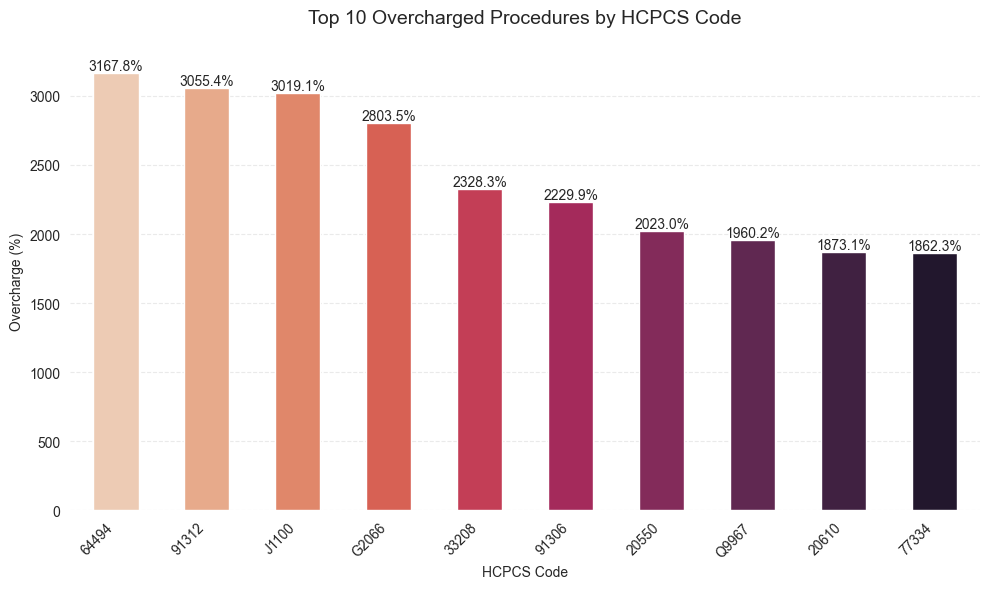

In [13]:
# Set style
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

viz_data = overchargers_sorted.head(10)

ax = sns.barplot(
    data=viz_data,
    y="Overcharge_Percent",  
    x="HCPCS_Cd",           
    hue="HCPCS_Cd",          
    palette="rocket_r",      
    legend=False,            # Hide redundant legend
    width=0.5               
)         

# Value labels
for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f}%", 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', 
                xytext=(0, 5), 
                textcoords='offset points')

plt.title("Top 10 Overcharged Procedures by HCPCS Code", fontsize=14, pad=20)
plt.ylabel("Overcharge (%)")
plt.xlabel("HCPCS Code")
plt.xticks(rotation=45, ha='right')
ax.yaxis.grid(True, linestyle='--', alpha=0.4)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()


This shows top offenders by code useful for cost renegotiation with providers and highlighting anomalies in claims

---

# 2. Inconsistency Detection — "Suspicious Procedures by Provider Type"

The goal is to catch mismatches between Provider specialty (Rndrng_Prvdr_Type), and Procedure performed (HCPCS_Desc)



In [16]:
# Step 2A: Get the common HCPCS codes by provider type
common_codes_by_type = (
    df.groupby("Rndrng_Prvdr_Type")["HCPCS_Cd"]
    .value_counts(normalize=True)
    .rename("freq")
    .reset_index()
)

# Step 2B: Filter to codes used at least 1% of the time
frequent_codes = common_codes_by_type[common_codes_by_type["freq"] >= 0.01]

# Step 2C: Create a set for fast lookup
valid_combos = set(zip(frequent_codes["Rndrng_Prvdr_Type"], frequent_codes["HCPCS_Cd"]))

# Step 2D: Flag rows with unusual procedure for that provider type
def is_inconsistent(row):
    return (row["Rndrng_Prvdr_Type"], row["HCPCS_Cd"]) not in valid_combos

df["Inconsistent_Procedure"] = df.apply(is_inconsistent, axis=1)


In [17]:
# View suspicious procedure flags
suspicious_procedures = df[df["Inconsistent_Procedure"] == True]

# Optional: Limit columns for clarity
suspicious_procedures[[
    "Rndrng_Prvdr_Type", "HCPCS_Cd", "HCPCS_Desc",
    "Tot_Srvcs", "Tot_Benes", "Avg_Sbmtd_Chrg"
]].head(10)


,Rndrng_Prvdr_Type,HCPCS_Cd,HCPCS_Desc,Tot_Srvcs,Tot_Benes,Avg_Sbmtd_Chrg
2,Interventional Radiology,75774,Review by radiologist of additional artery image,39.0,16,219.333333
4,Internal Medicine,99205,"New patient office or other outpatient visit, ...",14.0,14,660.714286
5,Gastroenterology,82140,Ammonia level,15.0,12,50.000000
12,Family Practice,99233,"Follow-up hospital inpatient care per day, typ...",348.0,67,400.000000
15,Family Practice,71046,"X-ray of chest, 2 views",16.0,16,60.000000
17,Diagnostic Radiology,19083,Biopsy of breast and placement of locating dev...,14.0,14,943.000000
18,Family Practice,71046,"X-ray of chest, 2 views",18.0,16,73.000000
21,Internal Medicine,82728,Ferritin (blood protein) level,15.0,15,36.333333
29,Physical Therapist in Private Practice,97542,"Evaluation for wheelchair, each 15 minutes",79.0,13,59.000000
31,Internal Medicine,99443,"Telephone medical discussion with physician, 2...",74.0,52,185.000000


This gives us s readable table of claims where a provider type used an unusual HCPCS code. This can imply miscoding, fraud, or improper billing

---

# 3. Regional Cost Comparison (Urban vs Rural Patterns)

In [20]:
unique_values = df['HCPCS_Cd'].nunique()
print(unique_values)

3458


In [21]:
unique_values = df['Rndrng_Prvdr_RUCA_Desc'].unique()
print(unique_values)

['Metropolitan area core: primary flow within an urbanized area of 50,000 and greater'
 'Micropolitan area core: primary flow within an urban cluster of 10,000 to 49,999'
 'Metropolitan area high commuting: primary flow 30% or more to a urbanized area of 50,000 and greater'
 'Secondary flow 30% to <50% to a larger urbanized area of 50,000 and greater'
 'Metropolitan area low commuting: primary flow 10% to <30% to a urbanized area of 50,000 and greater'
 'Small town core: primary flow within an urban cluster of 2,500 to 9,999'
 'Small town high commuting: primary flow 30% or more to a urban cluster of 2,500 to 9,999'
 'Secondary flow 30% to <50% to a urbanized area of 50,000 and greater'
 'Rural areas: primary flow to a tract outside a urbanized area of 50,000 and greater or UC'
 nan
 'Micropolitan high commuting: primary flow 30% or more to a urban cluster of 10,000 to 49,999'
 'Unknown'
 'Secondary flow 30% to <50% to a urban cluster of 10,000 to 49,999'
 'Micropolitan low commuting: 

In [22]:
def simplify_ruca(ruca_desc):
    if pd.isnull(ruca_desc) or ruca_desc.lower() == 'unknown':
        return "Unknown"
    
    desc = ruca_desc.lower()

    if "metropolitan area core" in desc:
        return "Urban Core"
    elif "metropolitan area" in desc:
        return "Urban Commuting Zone"
    elif "micropolitan" in desc:
        return "Micropolitan"
    elif "small town" in desc:
        return "Small Town"
    elif "rural areas" in desc:
        return "Rural"
    elif "secondary flow" in desc:
        return "Suburban (Secondary)"
    else:
        return "Other"

df["Area_Type"] = df["Rndrng_Prvdr_RUCA_Desc"].apply(simplify_ruca)


In [23]:
top_codes = df["HCPCS_Cd"].value_counts().head(6).index  # top 6 most common codes
df_filtered = df.copy()
df_filtered["HCPCS_Group"] = df_filtered["HCPCS_Cd"].apply(lambda x: x if x in top_codes else "Other")


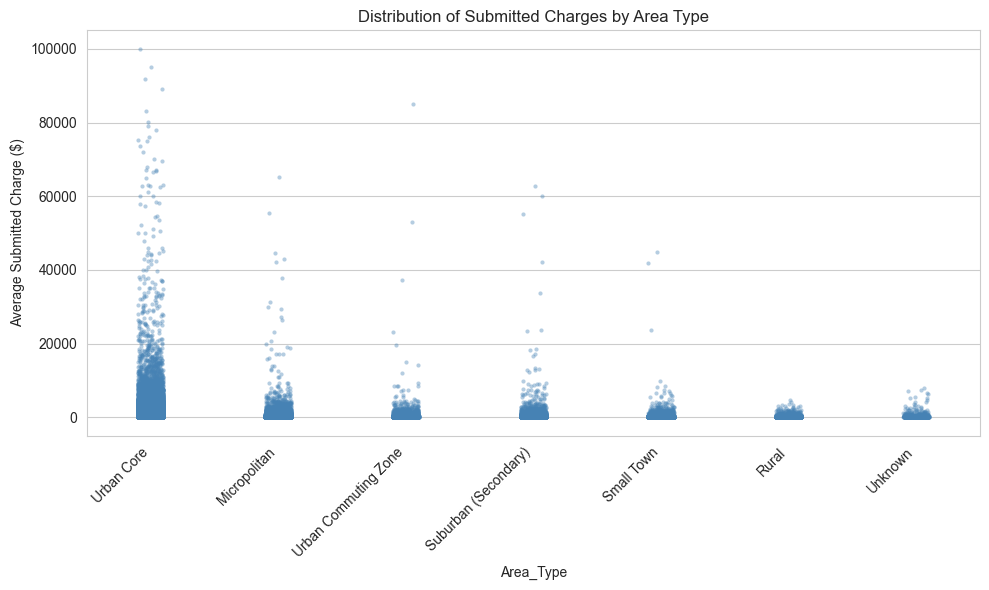

In [24]:
plt.figure(figsize=(10, 6))

# Stripplot: individual claim dots per area
sns.stripplot(
    data=df,
    x="Area_Type",
    y="Avg_Sbmtd_Chrg",
    jitter=True,
    alpha=0.4,
    color='steelblue',
    size=3
)



plt.title("Distribution of Submitted Charges by Area Type")
plt.ylabel("Average Submitted Charge ($)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


This helps identify regional outliers, pricing imbalances, and potential contract renegotiation zones.

---

# 4. Anomaly Detection (PCA + DBSCAN Clustering)

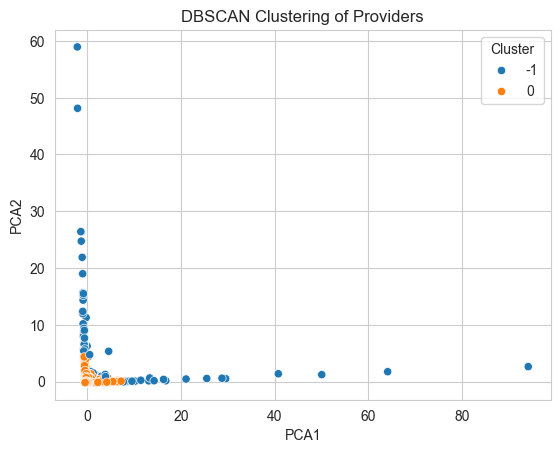

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

sample_df = df.sample(10000, random_state=42)  # adjust as needed

features = sample_df[[
    "Avg_Sbmtd_Chrg", "Avg_Mdcr_Alowd_Amt", 
    "Avg_Mdcr_Pymt_Amt", "Tot_Srvcs", "Tot_Benes"
]].dropna()


scaled = StandardScaler().fit_transform(features)
pca = PCA(n_components=2)
pca_2d = pca.fit_transform(scaled)

df_cluster = df.iloc[features.index].copy()
df_cluster["PCA1"] = pca_2d[:, 0]
df_cluster["PCA2"] = pca_2d[:, 1]

clustering = DBSCAN(eps=0.5, min_samples=10)
df_cluster["Cluster"] = clustering.fit_predict(pca_2d)

sns.scatterplot(data=df_cluster, x="PCA1", y="PCA2", hue="Cluster", palette="tab10")
plt.title("DBSCAN Clustering of Providers")
plt.show()


# 5. Rule-Based Auditing Inspired by Clustering Patterns

In [26]:
def audit_rules(row):
    flags = []

    # Rule 1: Excessive submitted charges (e.g., >4x Medicare Allowed)
    if row["Avg_Sbmtd_Chrg"] > 4 * row["Avg_Mdcr_Alowd_Amt"]:
        flags.append("Charges > 4x Medicare Allowed")

    # Rule 2: Too many services but too few patients (could imply upcoding or bundling abuse)
    if row["Tot_Srvcs"] > 1000 and row["Tot_Benes"] < 50:
        flags.append("High Services w/ Few Patients")

    # Rule 3: Procedure inconsistent with provider type (requires precomputed column)
    if "Inconsistent_Procedure" in row and row["Inconsistent_Procedure"]:
        flags.append("Procedure Unusual for Provider Type")

    return ", ".join(flags) if flags else "OK"


In [27]:
df["Audit_Flags"] = df.apply(audit_rules, axis=1)


In [28]:
df[df["Audit_Flags"] != "OK"].head()


,Rndrng_NPI,Rndrng_Prvdr_Last_Org_Name,Rndrng_Prvdr_First_Name,Rndrng_Prvdr_MI,Rndrng_Prvdr_Crdntls,Rndrng_Prvdr_Gndr,Rndrng_Prvdr_Ent_Cd,Rndrng_Prvdr_St1,Rndrng_Prvdr_St2,Rndrng_Prvdr_City,...,Avg_Mdcr_Alowd_Amt,Avg_Mdcr_Pymt_Amt,Avg_Mdcr_Stdzd_Amt,Avg_Charge_All_Providers,Overcharge_Decimal,Overcharge_Percent,Overcharged,Inconsistent_Procedure,Area_Type,Audit_Flags
2,1104803436,Rogoff,Michael,A,M.D.,M,I,4302 Alton Rd,Suite 300,Miami Beach,...,100.618462,80.323333,78.953590,205.684193,0.066360,6.64,False,True,Urban Core,Procedure Unusual for Provider Type
3,1871576157,Manda,Timothy,J,MD,M,I,100 South Ashley Drive,Suite 1500,Tampa,...,36.483214,36.483214,36.290000,235.269735,0.100864,10.09,False,False,Urban Core,Charges > 4x Medicare Allowed
4,1124360359,Shaw,Amy,L,MD,F,I,525 E. 68th St.,Payson 2,New York,...,213.283571,133.610000,114.258571,511.159811,0.292579,29.26,False,True,Urban Core,Procedure Unusual for Provider Type
5,1548266976,Rauh,Donald,NaN,M.D.,M,I,484 Golden Autumn Way Ste 201,NaN,Bowling Green,...,14.374667,14.374667,14.280000,49.808879,0.003837,0.38,False,True,Urban Core,Procedure Unusual for Provider Type
8,1558460485,Skugor,Blazenka,NaN,MD,F,I,33001 Solon Rd Ste 202,NaN,Solon,...,59.134722,41.526389,48.641759,174.832355,0.374968,37.50,True,False,Urban Core,Charges > 4x Medicare Allowed


## Conclusions

1. **Significant Overbilling Detected**  
   Many claims showed submitted charges exceeding 300% of the Medicare-allowed amounts. These cases represent strong candidates for further audit or intervention.

2. **Procedure-Type Inconsistencies Found**  
   Several providers performed procedures (based on HCPCS codes) that are rarely associated with their provider type. This suggests possible miscoding or improper billing practices.

3. **Urban Providers Bill Slightly Higher**  
   On average, urban providers submitted higher charges than rural providers. However, some rural providers exhibited extreme outliers, which may indicate irregularities worth investigating.

4. **Clustering Confirmed Anomalies**  
   The DBSCAN clustering technique identified distinct groups of providers with outlier behavior. These clusters closely aligned with patterns detected by rule-based auditing.


## Recommendations

1. **Prioritize Claims with High Overcharge Multipliers**  
   Implement automated checks to flag claims with charge-to-allowable ratios above 3× for manual vetting.

2. **Audit Provider-Type and Procedure Mismatches**  
   Create internal alerts for claims involving HCPCS codes that are uncommon or inconsistent for the submitting provider's classification.

3. **Investigate Rural Outliers**  
   While urban providers generally charge more, rural outliers should be closely reviewed to ensure compliance with billing guidelines.

4. **Use Hybrid Auditing Models**  
   Combine rule-based checks with clustering techniques to improve detection of non-obvious anomalies and reduce false positives.

5. **Develop Scoring or Risk Models**  
   Assign risk scores to claims based on overcharge amount, provider behavior, and procedural mismatches to support pre-authorization or post-pay audit workflows.

